<a href="https://colab.research.google.com/github/rezahamzeh69/Optimized-Bidirectional-LSTM-Intrusion-Detection/blob/main/LSTM_model_on_UNSW_NB15_dataset_V_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trial 5 Complete [00h 02m 57s]
val_accuracy: 0.9996007680892944

Best val_accuracy So Far: 0.9999715089797974
Total elapsed time: 00h 23m 09s
Best hyperparameters:
{'units_1': 32, 'dropout_1': 0.30000000000000004, 'r_dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.30000000000000004, 'r_dropout_2': 0.5, 'optimizer': 'adam'}
Epoch 1/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9364 - loss: 0.1678 - val_accuracy: 0.9995 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.9905 - loss: 0.0243 - val_accuracy: 0.9994 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9953 - loss: 0.0125 - val_accuracy: 0.9937 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9972 - loss: 0.0078 - val_accuracy: 0.9920 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 5/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/s

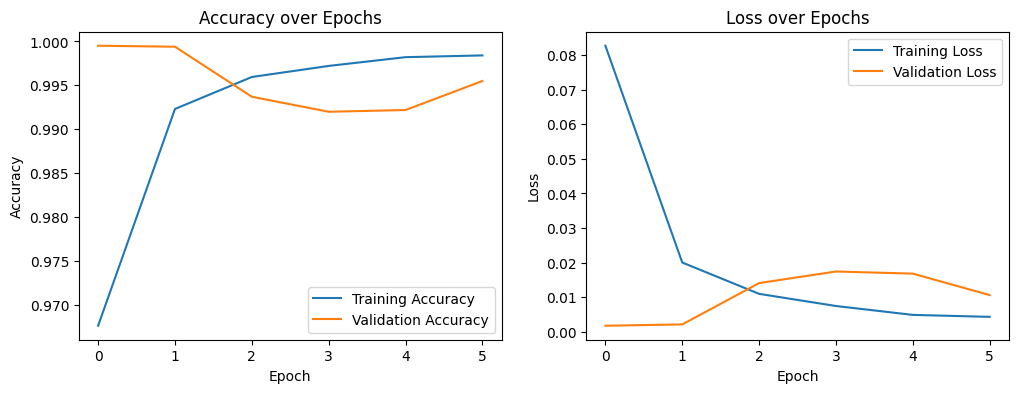

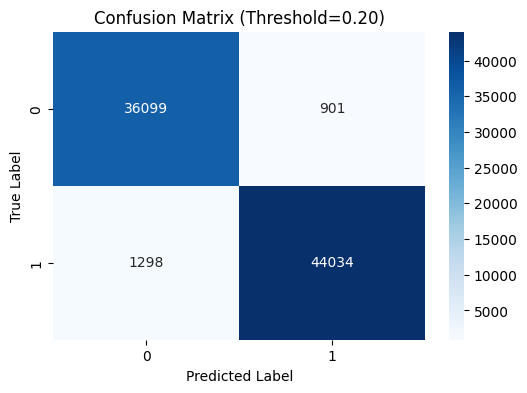

In [1]:
# Install required libraries (if they are not already installed)
!pip install keras-tuner --upgrade --quiet
!pip install imblearn --upgrade --quiet

# -------------------------------------------
# Import required libraries
# -------------------------------------------
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Install SMOTE from imblearn and Keras Tuner
from imblearn.over_sampling import SMOTE
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------------------
# Helper function to find files in the current directory
# -------------------------------------------
def find_file(patterns):
    """
    Searches for a file in the current directory whose name contains
    any of the specified patterns. Returns the first match found.
    """
    for file in os.listdir():
        for pattern in patterns:
            if pattern.lower() in file.lower():
                return file
    return None

# -------------------------------------------
# Define expected patterns for training and testing files
# -------------------------------------------
training_patterns = ["training", "unsw_nb15_training"]
testing_patterns  = ["testing", "unsw_nb15_testing"]

training_filename = find_file(training_patterns)
testing_filename  = find_file(testing_patterns)

# If files are not found locally, prompt for upload (e.g., in Google Colab)
if training_filename and testing_filename:
    print("Files found in the current directory:")
    print("Training file:", training_filename)
    print("Testing file:", testing_filename)
else:
    from google.colab import files
    uploaded = files.upload()  # Upload the training and testing CSV files
    keys = list(uploaded.keys())
    print("Uploaded files:", keys)
    if not training_filename:
        training_filename = [k for k in keys if "training" in k.lower()][0]
    if not testing_filename:
        testing_filename = [k for k in keys if "testing" in k.lower()][0]

# -------------------------------------------
# Read the CSV files into DataFrames
# -------------------------------------------
if os.path.exists(training_filename):
    train_df = pd.read_csv(training_filename)
else:
    train_df = pd.read_csv(io.BytesIO(uploaded[training_filename]))

if os.path.exists(testing_filename):
    test_df = pd.read_csv(testing_filename)
else:
    test_df = pd.read_csv(io.BytesIO(uploaded[testing_filename]))

print("Training DataFrame shape:", train_df.shape)
print("Testing DataFrame shape:", test_df.shape)

# -------------------------------------------
# Create a binary label if needed (0 for Normal, 1 for Attack)
# -------------------------------------------
if 'label' not in train_df.columns:
    train_df['label'] = train_df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)
if 'label' not in test_df.columns:
    test_df['label'] = test_df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)

# -------------------------------------------
# Separate features (X) and labels (y)
# -------------------------------------------
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']
X_test  = test_df.drop(['label'], axis=1)
y_test  = test_df['label']

# -------------------------------------------
# Process nominal (categorical) columns using One-Hot Encoding
# -------------------------------------------
nominal_cols = ['proto', 'service', 'state']
existing_nominal_cols = [col for col in nominal_cols if col in X_train.columns]

if existing_nominal_cols:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit and transform on training data
    train_encoded = ohe.fit_transform(X_train[existing_nominal_cols])
    encoded_feature_names = ohe.get_feature_names_out(existing_nominal_cols)
    train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_feature_names, index=X_train.index)
    X_train.drop(existing_nominal_cols, axis=1, inplace=True)
    X_train = pd.concat([X_train, train_encoded_df], axis=1)

    # Transform on testing data
    test_encoded = ohe.transform(X_test[existing_nominal_cols])
    test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names, index=X_test.index)
    X_test.drop(existing_nominal_cols, axis=1, inplace=True)
    X_test = pd.concat([X_test, test_encoded_df], axis=1)

# Process any remaining categorical columns with LabelEncoder
remaining_categorical_train = X_train.select_dtypes(include=['object']).columns
for col in remaining_categorical_train:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])

remaining_categorical_test = X_test.select_dtypes(include=['object']).columns
for col in remaining_categorical_test:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col])

# -------------------------------------------
# Check class imbalance and apply SMOTE if needed
# -------------------------------------------
class_counts = y_train.value_counts()
print("Class distribution in the training set:\n", class_counts)

minority_ratio = class_counts.min() / class_counts.sum()
if minority_ratio < 0.3:
    print("Classes are imbalanced. Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    print("Classes are relatively balanced. No need for SMOTE.")

# -------------------------------------------
# Normalize features using StandardScaler
# -------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Reshape data for LSTM: (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# -------------------------------------------
# Define the model-building function for hyperparameter tuning with Keras Tuner
# -------------------------------------------
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(
        Bidirectional(
            LSTM(
                units_1,
                return_sequences=True,
                dropout=hp.Float('dropout_1', 0.1, 0.5, step=0.1),
                recurrent_dropout=hp.Float('r_dropout_1', 0.1, 0.5, step=0.1)
            ),
            input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
        )
    )

    # Second LSTM layer
    units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
    model.add(
        Bidirectional(
            LSTM(
                units_2,
                dropout=hp.Float('dropout_2', 0.1, 0.5, step=0.1),
                recurrent_dropout=hp.Float('r_dropout_2', 0.1, 0.5, step=0.1)
            )
        )
    )

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Choose the optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    model.compile(loss='binary_crossentropy', optimizer=optimizer_choice, metrics=['accuracy'])

    return model

# -------------------------------------------
# Random Search with Keras Tuner
# -------------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # number of trials (can be increased for a more thorough search)
    executions_per_trial=1,
    overwrite=True,
    directory='my_tuner_dir',
    project_name='unsw_nb15_lstm'
)

early_stop_tuner = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    X_train_scaled, y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stop_tuner],
    batch_size=64
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

# Build the final model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# -------------------------------------------
# Train the final model with the best hyperparameters
# -------------------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = best_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# -------------------------------------------
# Initial evaluation with threshold = 0.5
# -------------------------------------------
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print("Test loss (Threshold=0.5):", loss)
print("Test accuracy (Threshold=0.5):", accuracy)

y_pred_prob = best_model.predict(X_test_scaled)
y_pred_05 = (y_pred_prob > 0.5).astype("int32")

print("\nClassification report (Threshold=0.5):")
print(classification_report(y_test, y_pred_05))

# -------------------------------------------
# Threshold tuning based on F1-score
# -------------------------------------------
thresholds = np.arange(0.1, 1.0, 0.1)
best_threshold = 0.5
best_f1 = 0.0

for th in thresholds:
    y_pred_th = (y_pred_prob > th).astype("int32")
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_th, average='binary')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = th

print(f"\nBest threshold based on F1-score: {best_threshold:.2f} with F1={best_f1:.3f}")

y_pred_best = (y_pred_prob > best_threshold).astype("int32")
print(f"\nClassification report (Threshold={best_threshold:.2f}):")
print(classification_report(y_test, y_pred_best))

# -------------------------------------------
# Plot accuracy and loss over epochs
# -------------------------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# -------------------------------------------
# Plot confusion matrix with the best threshold
# -------------------------------------------
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
